# 21차시: [실습] 분류 분석(Logistic Regression)으로 상승/하락 예측

## 학습 목표
- 분류 문제의 개념과 회귀와의 차이점 이해
- 로지스틱 회귀(LogisticRegression)로 주가 상승/하락 예측 모델 구축
- FRED API로 환율 데이터를 추가 특성으로 활용
- 분류 모델 평가 지표 (Accuracy, Precision, Recall, F1) 학습

## 학습 내용
1. 이진분류란?
2. 데이터 수집 (주가 + 환율)
3. 특성 공학 (Feature Engineering)
4. LogisticRegression 모델 학습
5. 모델 평가 및 시각화

## 중요 주의사항 (Warning)

본 교재와 실습에서 사용하는 모든 데이터, 모델, 기법은
오직 머신러닝·분류 개념 이해와 교육 목적을 위한 예제입니다. 따라서,
실제 금융 시장의 복잡성, 리스크, 거래 비용, 정책·심리 요인 등을 전혀 반영하지 못하며, 실제 투자 판단이나 매매 전략에 사용해서는 안 됩니다.

👉 실습 결과는 “참고용·학습용”으로만 활용하시기 바랍니다.

In [1]:
!pip install -Uq finance-datareader koreanize-matplotlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
from datetime import datetime, timedelta
from IPython.display import display

---
## 1. 이진분류란?

### 회귀 vs 분류
| 구분 | 회귀 (Regression) | 분류 (Classification) |
|------|-------------------|----------------------|
| 출력 | 연속값 (주가) | 범주 (상승/하락) |
| 질문 | 내일 주가는 얼마? | 내일 오를까 내릴까? |
| 알고리즘 | LinearRegression | LogisticRegression |
| 평가 | MSE, R2 | Accuracy, F1 |

### 이진분류 문제 정의
```
입력(X): 오늘의 주가 관련 특성들 + 환율 데이터
출력(y): 내일 상승(1) 또는 하락(0)
```

### LogisticRegression 원리
- 이름에 "Regression"이 있지만 **분류** 알고리즘
- Sigmoid 함수로 출력을 0~1 사이의 확률로 변환
- 확률이 0.5 이상이면 1(상승), 미만이면 0(하락)

$$
P(y=1 \mid X) = \frac{1}{1 + e^{-z}}
$$

$$
z = \beta_0 + \beta_1 x_1 + \cdots + \beta_n x_n
$$

---
## 2. 데이터 수집 (주가 + 환율)

### 2.1 주가 데이터 수집 (FinanceDataReader)

In [3]:
import FinanceDataReader as fdr

# 날짜 설정 (최근 1년)
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

print("[주가 데이터 수집]")
print("=" * 50)
print(f"기간: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')}")
print("종목: 삼성전자 (005930)")

# 삼성전자 주가 데이터 수집 (FinanceDataReader - Module 01/02와 동일)
df = fdr.DataReader("005930", start_date, end_date)

print(f"\n수집된 데이터: {len(df)}개")
display(df.tail())

[주가 데이터 수집]
기간: 2025-01-06 ~ 2026-01-06
종목: 삼성전자 (005930)

수집된 데이터: 242개


,Open,High,Low,Close,Volume,Change
Date,,,,,,
2025-12-29,119400,119700,118200,119500,19676004,0.021368
2025-12-30,119100,121200,118700,119900,19746349,0.003347
2026-01-02,120200,128500,120200,128500,30463279,0.071726
2026-01-05,134600,138600,133600,138100,42863376,0.074708
2026-01-06,135300,139300,132700,138900,45208323,0.005793


In [4]:
# 기본 통계
print("[기본 통계]")
print("=" * 50)
print(f"종가 범위: {df['Close'].min():,}원 ~ {df['Close'].max():,}원")
print(f"평균 종가: {df['Close'].mean():,.0f}원")
print(f"평균 거래량: {df['Volume'].mean():,.0f}주")

[기본 통계]
종가 범위: 51,000원 ~ 138,900원
평균 종가: 72,447원
평균 거래량: 19,543,049주


### 2.2 환율 데이터 수집 (FRED API)

FRED에서 USD/KRW 환율 데이터를 가져옵니다. (Module 02에서 학습한 내용 활용)

In [5]:
import pandas_datareader.data as web
from dotenv import load_dotenv
import os

# .env 파일에서 FRED API 키 로드 (Module 02와 동일)
# Colab에서는 파일 업로드 후 사용
try:
    from google.colab import files
    print("Colab 환경: .env 파일을 업로드하세요")
    uploaded = files.upload()
    load_dotenv('.env')
except:
    load_dotenv()

FRED_API_KEY = os.getenv('FRED_API_KEY')

if FRED_API_KEY:
    print(f"FRED API 키 로드 완료: {FRED_API_KEY[:8]}...")
else:
    print("FRED API 키가 없습니다. 환율 데이터 없이 진행합니다.")

Colab 환경: .env 파일을 업로드하세요


Saving .env to .env (2)
FRED API 키 로드 완료: 061718d0...


In [6]:
print("[환율 데이터 수집 - FRED]")
print("=" * 50)
print("시리즈: DEXKOUS (USD/KRW 환율)")

# FRED에서 환율 데이터 수집
try:
    df_fx = web.DataReader('DEXKOUS', 'fred', start_date, end_date)
    df_fx.columns = ['환율']

    # 결측치 처리 (주말/공휴일 → 전일 값으로 채움)
    df_fx = df_fx.ffill()

    print(f"수집된 환율 데이터: {len(df_fx)}개")
    print(f"환율 범위: {df_fx['환율'].min():,.2f}원 ~ {df_fx['환율'].max():,.2f}원")
    display(df_fx.tail())

    fx_available = True
except Exception as e:
    print(f"환율 데이터 수집 실패: {e}")
    print("환율 데이터 없이 진행합니다.")
    fx_available = False

[환율 데이터 수집 - FRED]
시리즈: DEXKOUS (USD/KRW 환율)
수집된 환율 데이터: 259개
환율 범위: 1,353.50원 ~ 1,481.45원


,환율
DATE,
2025-12-29,1433.88
2025-12-30,1439.42
2025-12-31,1444.55
2026-01-01,1444.55
2026-01-02,1444.45


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 242 entries, 2025-01-07 to 2026-01-06
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    242 non-null    int64  
 1   High    242 non-null    int64  
 2   Low     242 non-null    int64  
 3   Close   242 non-null    int64  
 4   Volume  242 non-null    int64  
 5   Change  242 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 13.2 KB


In [8]:
df_fx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 259 entries, 2025-01-07 to 2026-01-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   환율      259 non-null    float64
dtypes: float64(1)
memory usage: 4.0 KB


In [9]:
# 주가 데이터와 환율 데이터 병합
if fx_available:
    df = df.merge(df_fx, left_index=True, right_index=True, how='left')

    # 환율 결측치 처리 (주식 거래일과 환율 데이터 불일치 시)
    df['환율'] = df['환율'].ffill().bfill()  # 앞의 값으로 먼저 채우고, 그래도 남으면 뒤의 값으로 채운다

    print("[데이터 병합 완료]")
    print("=" * 50)
    print(f"병합 후 데이터: {len(df)}개")
    display(df[['Close', 'Volume', '환율']].tail())

[데이터 병합 완료]
병합 후 데이터: 242개


,Close,Volume,환율
Date,,,
2025-12-29,119500,19676004,1433.88
2025-12-30,119900,19746349,1439.42
2026-01-02,128500,30463279,1444.45
2026-01-05,138100,42863376,1444.45
2026-01-06,138900,45208323,1444.45


---
## 3. 특성 공학 (Feature Engineering)

주가 예측에 유용한 특성들을 생성합니다. (20차시 내용 + 환율 특성 추가)

In [10]:
# 특성 생성 (핵심 특성만 간단히 - 20차시와 동일)
df['전일종가'] = df['Close'].shift(1)           # 전일 종가
df['수익률'] = df['Close'].pct_change() * 100   # 전일 대비 수익률 (%)
df['5일이동평균'] = df['Close'].rolling(5).mean()  # 5일 이동평균
df['거래량비율'] = df['Volume'] / df['Volume'].rolling(20).mean()  # 평균 대비 거래량

# 환율 특성 (FRED 데이터 활용)
if fx_available:
    df['환율변화율'] = df['환율'].pct_change() * 100  # 전일 대비 환율 변화율 (%)

In [11]:
# 결측치 제거
df = df.dropna()
print(f"\n결측치 제거 후 데이터: {len(df)}개")
df.head()


결측치 제거 후 데이터: 223개


,Open,High,Low,Close,Volume,Change,환율,전일종가,수익률,5일이동평균,거래량비율,환율변화율
Date,,,,,,,,,,,,
2025-02-07,53900,54200,53600,53700,14476866,-0.005556,1453.97,54000.0,-0.555556,52860.0,0.734148,0.478214
2025-02-10,53000,55900,52900,55600,27577591,0.035382,1451.00,53700.0,3.538175,53780.0,1.362082,-0.204268
2025-02-11,55500,56300,55000,55700,24596196,0.001799,1452.31,55600.0,0.179856,54380.0,1.220850,0.090283
2025-02-12,55100,55900,54500,55800,26428596,0.001795,1453.49,55700.0,0.179533,54960.0,1.305524,0.081250
2025-02-13,56100,56400,55600,55800,22448377,0.000000,1446.95,55800.0,0.000000,55320.0,1.091681,-0.449951


In [12]:
# 타겟 변수 생성: 다음날 상승(1) / 하락(0)
df['다음날종가'] = df['Close'].shift(-1)
df['다음날상승'] = (df['다음날종가'] > df['Close']).astype(int)
df = df.dropna()
df.head()

,Open,High,Low,Close,Volume,Change,환율,전일종가,수익률,5일이동평균,거래량비율,환율변화율,다음날종가,다음날상승
Date,,,,,,,,,,,,,,
2025-02-07,53900,54200,53600,53700,14476866,-0.005556,1453.97,54000.0,-0.555556,52860.0,0.734148,0.478214,55600.0,1
2025-02-10,53000,55900,52900,55600,27577591,0.035382,1451.00,53700.0,3.538175,53780.0,1.362082,-0.204268,55700.0,1
2025-02-11,55500,56300,55000,55700,24596196,0.001799,1452.31,55600.0,0.179856,54380.0,1.220850,0.090283,55800.0,1
2025-02-12,55100,55900,54500,55800,26428596,0.001795,1453.49,55700.0,0.179533,54960.0,1.305524,0.081250,55800.0,0
2025-02-13,56100,56400,55600,55800,22448377,0.000000,1446.95,55800.0,0.000000,55320.0,1.091681,-0.449951,56000.0,1


In [13]:
print("=" * 50)
print("다음날상승 = 1 if 다음날종가 > 오늘종가 else 0")
print()
print(f"상승 일수: {df['다음날상승'].sum()}일 ({df['다음날상승'].mean()*100:.1f}%)")
print(f"하락 일수: {len(df) - df['다음날상승'].sum()}일 ({(1-df['다음날상승'].mean())*100:.1f}%)")

다음날상승 = 1 if 다음날종가 > 오늘종가 else 0

상승 일수: 124일 (55.9%)
하락 일수: 98일 (44.1%)


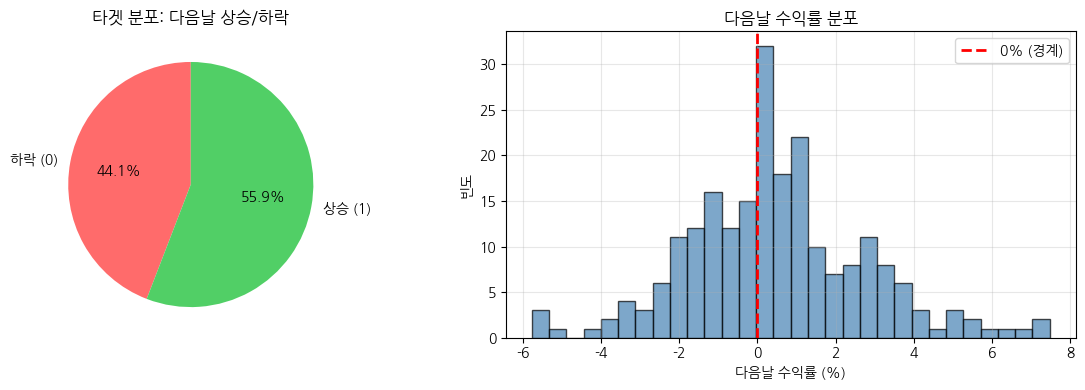

In [14]:
# 상승/하락 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1. 파이 차트
labels = ['하락 (0)', '상승 (1)']
sizes = [len(df) - df['다음날상승'].sum(), df['다음날상승'].sum()]
colors = ['#ff6b6b', '#51cf66']
axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0].set_title('타겟 분포: 다음날 상승/하락')

# 2. 수익률 히스토그램
df['다음날수익률'] = (df['다음날종가'] - df['Close']) / df['Close'] * 100
axes[1].hist(df['다음날수익률'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='0% (경계)')
axes[1].set_xlabel('다음날 수익률 (%)')
axes[1].set_ylabel('빈도')
axes[1].set_title('다음날 수익률 분포')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

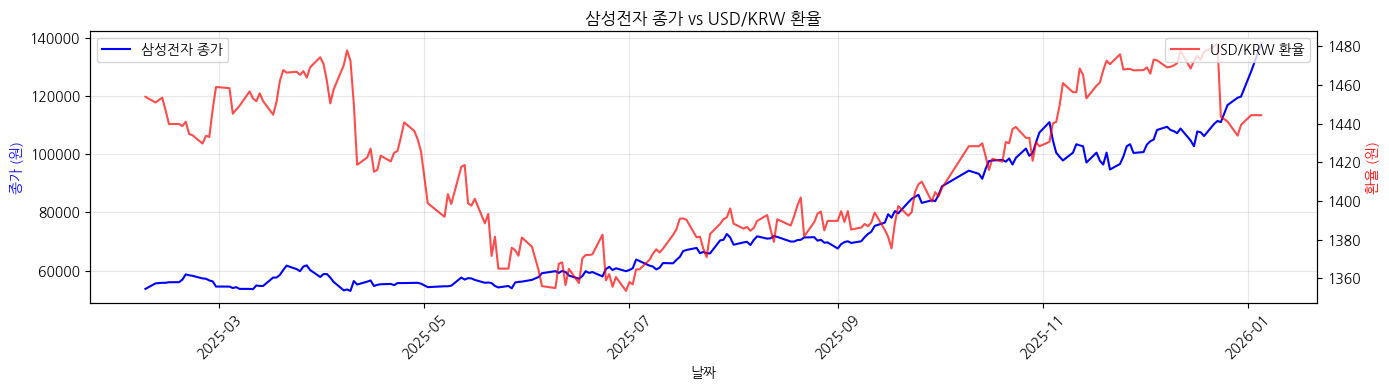

In [15]:
# 환율과 주가의 관계 시각화 (종가 vs 환율만)
if fx_available:
    fig, ax1 = plt.subplots(figsize=(14, 4))

    # 보조 y축 생성
    ax2 = ax1.twinx()

    # 삼성전자 종가
    ax1.plot(df.index, df['Close'],
             'b-', label='삼성전자 종가', linewidth=1.5)

    # USD/KRW 환율
    ax2.plot(df.index, df['환율'],
             'r-', label='USD/KRW 환율', linewidth=1.5, alpha=0.7)

    # 축 설정
    ax1.set_xlabel('날짜')
    ax1.set_ylabel('종가 (원)', color='blue')
    ax2.set_ylabel('환율 (원)', color='red')

    ax1.tick_params(axis='x', rotation=45)

    # 범례
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # 제목 및 그리드
    ax1.set_title('삼성전자 종가 vs USD/KRW 환율')
    ax1.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

---
## 4. LogisticRegression 모델 학습

### 예측 대상 정의
**타겟(y)**: 다음날 상승(1) 또는 하락(0)

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# 특성과 타겟 분리 (환율 특성 포함)
if fx_available:
    feature_cols = ['전일종가', '수익률', '5일이동평균', '거래량비율', '환율변화율']
else:
    feature_cols = ['전일종가', '수익률', '5일이동평균', '거래량비율']

X = df[feature_cols]
y = df['다음날상승']

print("[데이터셋 구성]")
print("=" * 50)
print(f"특성 (X): {len(feature_cols)}개")
for col in feature_cols:
    print(f"  - {col}")
print(f"\n타겟 (y): 다음날상승 (0=하락, 1=상승)")
print(f"샘플 수: {len(X)}개")

[데이터셋 구성]
특성 (X): 5개
  - 전일종가
  - 수익률
  - 5일이동평균
  - 거래량비율
  - 환율변화율

타겟 (y): 다음날상승 (0=하락, 1=상승)
샘플 수: 222개


In [17]:
# 데이터 분할 (시계열이므로 섞지 않음 - 80:20)
split_idx = int(len(X) * 0.8)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\n[데이터 분할]")
print(f"학습 데이터: {len(X_train)}개")
print(f"테스트 데이터: {len(X_test)}개")
print(f"테스트 상승 비율: {y_test.mean():.1%}")


[데이터 분할]
학습 데이터: 177개
테스트 데이터: 45개
테스트 상승 비율: 57.8%


In [18]:
# 스케일링 (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# LogisticRegression 모델 학습
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

print("[LogisticRegression 모델 학습 완료]")

[LogisticRegression 모델 학습 완료]


In [20]:
# 예측
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # 상승 확률

---
## 5. 모델 평가 및 시각화

### 분류 평가 지표
| 지표 | 수식 | 의미 |
|------|------|------|
| Accuracy | (TP+TN)/전체 | 전체 정확도 |

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("[모델 평가 결과]")
print("=" * 50)
print(f"Accuracy:  {accuracy:.1%} (전체 중 맞춘 비율)")

[모델 평가 결과]
Accuracy:  57.8% (전체 중 맞춘 비율)


In [22]:
# 최근 예측 결과 상세
print("[최근 10일 예측 결과]")
print("=" * 70)

result_cols = ['날짜', 'Close', '실제', '예측',  '정답']
if fx_available:
    recent_results = pd.DataFrame({
        '날짜': df.index[split_idx:split_idx+len(y_test)][-10:],
        '종가': df['Close'].iloc[split_idx:split_idx+len(y_test)].values[-10:],
        '환율': df['환율'].iloc[split_idx:split_idx+len(y_test)].values[-10:].round(2),
        '실제': ['상승' if v == 1 else '하락' for v in y_test.values[-10:]],
        '예측': ['상승' if v == 1 else '하락' for v in y_pred[-10:]],
        '정답': ['O' if a == p else 'X' for a, p in zip(y_test.values[-10:], y_pred[-10:])]
    })
else:
    recent_results = pd.DataFrame({
        '날짜': df.index[split_idx:split_idx+len(y_test)][-10:],
        '종가': df['종가'].iloc[split_idx:split_idx+len(y_test)].values[-10:],
        '실제': ['상승' if v == 1 else '하락' for v in y_test.values[-10:]],
        '예측': ['상승' if v == 1 else '하락' for v in y_pred[-10:]],
        '정답': ['O' if a == p else 'X' for a, p in zip(y_test.values[-10:], y_pred[-10:])]
    })

display(recent_results)

[최근 10일 예측 결과]


,날짜,종가,환율,실제,예측,정답
0,2025-12-18,107600,1473.21,하락,상승,X
1,2025-12-19,106300,1477.26,상승,상승,O
2,2025-12-22,110500,1480.13,상승,상승,O
3,2025-12-23,111500,1481.45,하락,상승,X
4,2025-12-24,111100,1443.62,상승,상승,O
5,2025-12-26,117000,1441.16,상승,상승,O
6,2025-12-29,119500,1433.88,상승,상승,O
7,2025-12-30,119900,1439.42,상승,상승,O
8,2026-01-02,128500,1444.45,상승,상승,O
9,2026-01-05,138100,1444.45,상승,상승,O


---
## 학습 정리

### 1. 이진분류 워크플로우
```
데이터 수집 (주가+환율) → 타겟 생성(0/1) → 특성 생성 → 스케일링 → 모델 학습 → 평가
```

### 2. 핵심 코드
```python
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas_datareader.data as web

# 환율 데이터 수집 (FRED)
df_fx = web.DataReader('DEXKOUS', 'fred', start_date, end_date)

# 타겟 생성: 내일 주가가 오를지 내릴지
df['다음날상승'] = (df['종가'].shift(-1) > df['종가']).astype(int)

# 모델 학습 (주가 + 환율 특성)
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# 예측 및 평가
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
```

### 3. 주요 평가 지표
| 지표 | 용도 |
|------|------|
| Accuracy | 전체 정확도 (균형 데이터) |

### 4. 환율 특성 활용
- FRED API로 USD/KRW 환율 수집 (Module 02 연계)
- 환율변화율을 특성으로 추가
- 수출 기업(삼성전자)은 환율과 상관관계 분석 가능

### 5. 주의사항
- 주가 방향 예측도 매우 어려운 문제
- 50% 이상이면 랜덤보다 나음
- 과적합 및 데이터 누수 주의

---

### 다음 차시 예고
- 22차시: 모델 성능 평가 심화
  - 회귀 vs 분류 평가 비교
  - ROC Curve, AUC
  - 교차 검증